<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Distributed computing with MPI

## Contents


In this notebook, we will learn the basics of parallel computing using the Message Passing Interface (MPI) from Julia. In particular, we will learn:

- How to run parallel MPI code in Julia
- How to use basic collective communication directives
- How to use basic point-to-point communication directives

For further information on how to use MPI from Julia see https://github.com/JuliaParallel/MPI.jl


## What is MPI ?

- MPI stands for the "Message Passing Interface"
- It is a standardized library specification for communication between parallel processes in distributed-memory systems.
- It is the gold-standard for distributed computing in HPC systems since the 90s
- It is huge: the MPI standard has more than 1k pages (see https://www.mpi-forum.org/docs/mpi-4.0/mpi40-report.pdf)
- There are several implementations of this standard (OpenMPI, MPICH, IntelMPI)
- The interface is in C and FORTRAN (C++ was deprecated)
- There are Julia bindings via the package MPI.jl https://github.com/JuliaParallel/MPI.jl

### Installing MPI in Julia

MPI can be installed as any other Julia package using the package manager.

In [ ]:
] add MPI

<div class="alert alert-block alert-info">
<b>Note:</b> The package you have installed it is the Julia interface to MPI, called MPI.jl. Note that it is not a MPI library by itself. It is just a thin wrapper between MPI and Julia. To use this interface, you need an actual MPI library installed in your system such as OpenMPI or MPICH. Julia downloads and installs a MPI library for you, but it is also possible to use a MPI library already available in your system. This is useful, e.g., when running on HPC clusters. See the documentation of MPI.jl for further details. See more information in <a href="https://github.com/JuliaParallel/MPI.jl">https://github.com/JuliaParallel/MPI.jl</a>
</div>

### Hello-world example

In [ ]:
using MPI
MPI.Init()
comm = MPI.COMM_WORLD
nranks = MPI.Comm_size(comm)
rank = MPI.Comm_rank(comm)
println("Hello, I am process $rank of $nranks processes!")

## Running MPI code

### Creating MPI processes (aka ranks)

- MPI processes are created with the driver program `mpiexec`
- `mpiexec` takes an application and runs it on different ranks
- The application calls MPI directives to communicate between these ranks
- The application can be Julia running your script in particular.


 <div>
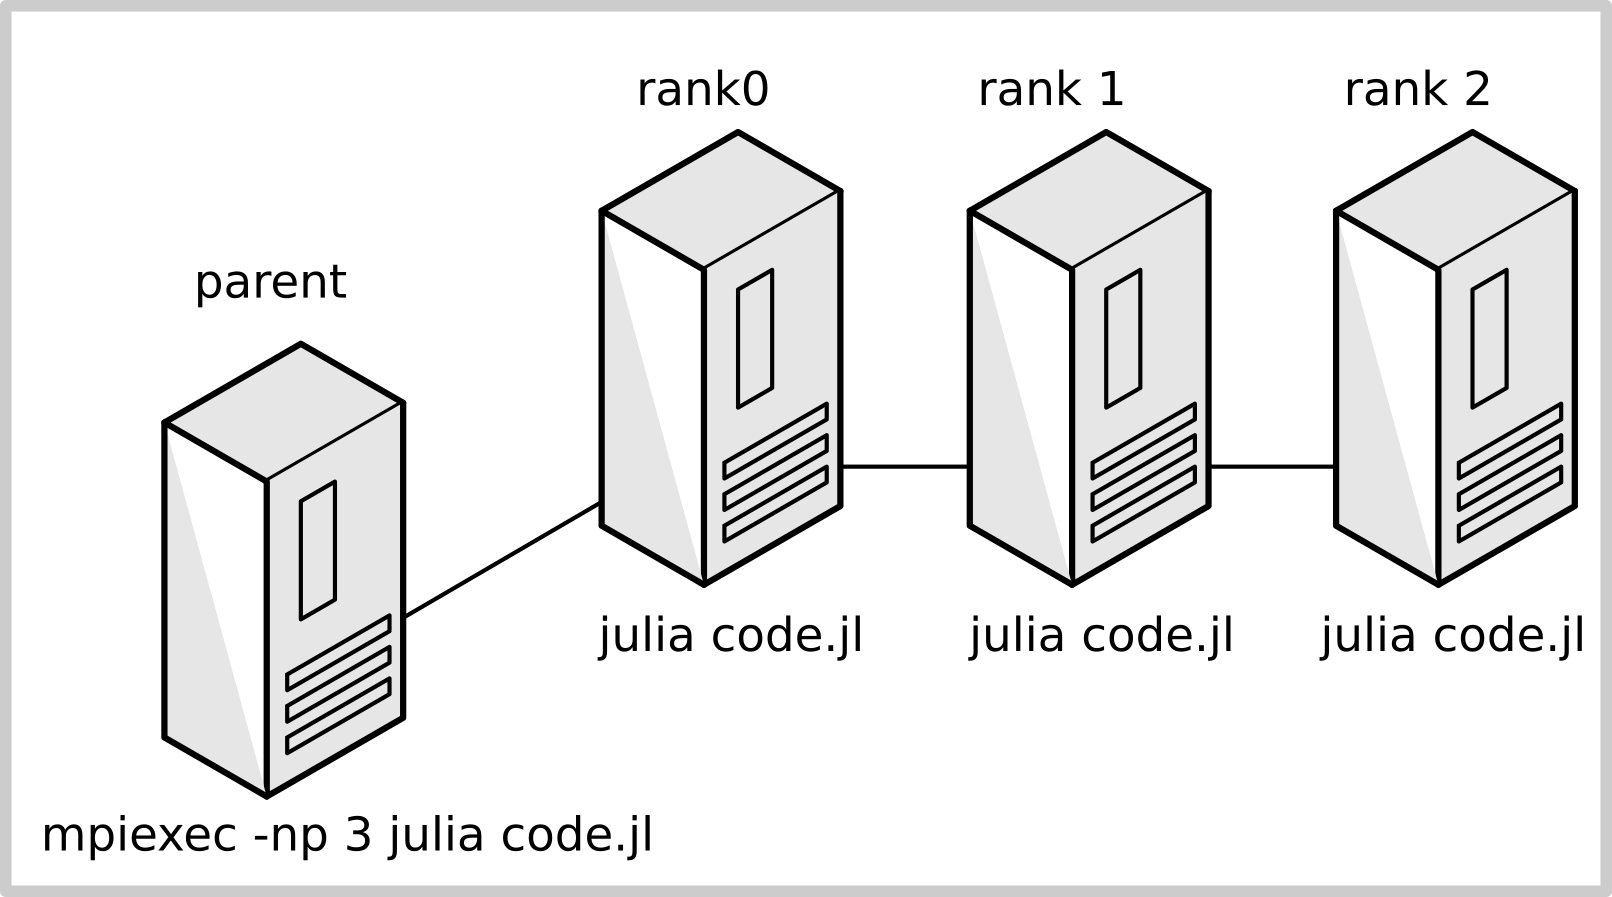
</div>
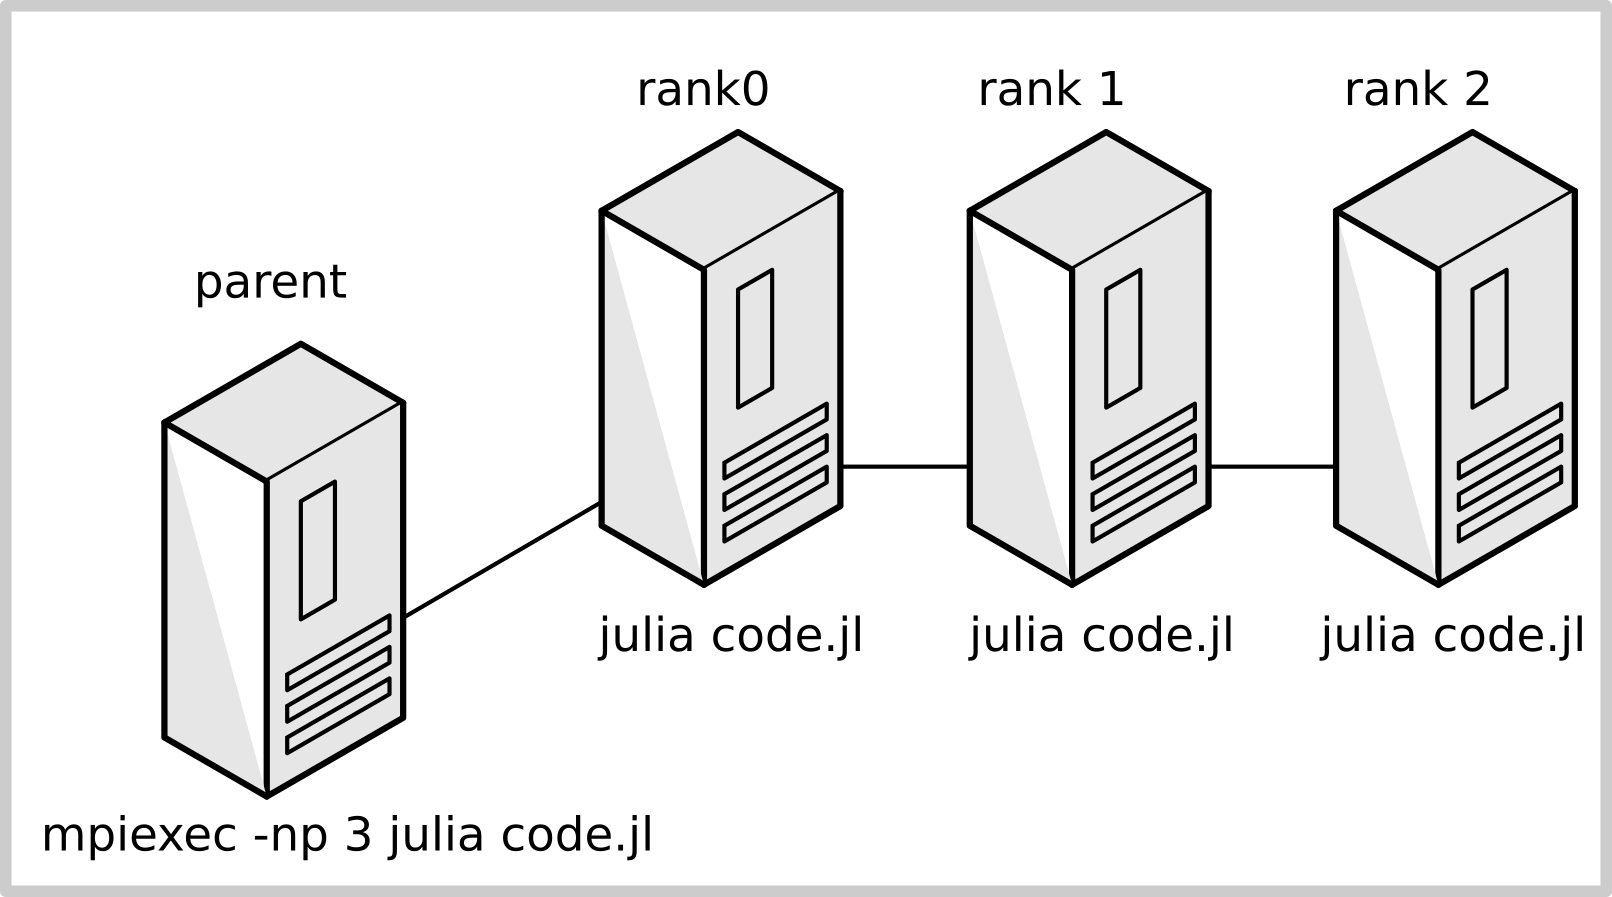

### Execution model

- MPI programs are typically run with a Single Program Multiple Data (SPMD) model
- But the standard supports Multiple Program Multiple Data (MPMD)

### Hello world

Julia code typically needs to be in a file to run it in with MPI. Let's us write our hello world in a file:

In [ ]:
code = raw"""
using MPI
MPI.Init()
comm = MPI.COMM_WORLD
nranks = MPI.Comm_size(comm)
rank = MPI.Comm_rank(comm)
println("Hello, I am process $rank of $nranks processes!")
"""
filename = tempname()*".jl"
write(filename,code);

Now, we can run it

In [ ]:
using MPI
mpiexec(cmd->run(`$cmd -np 4 julia --project=. $filename`));

Note that function mpiexec provided by MPI.jl is a convenient way of accessing the mpiexec program that matches the MPI installation used my Julia.

###  MPIClusterManagers 

- This package allows you to create Julia workers that can call MPI functions
- This is useful to combine Distributed.jl and MPI.jl
- E.g., we can run MPI code interactively (from a notebook)
- Link: https://github.com/JuliaParallel/MPIClusterManagers.jl


 <div>
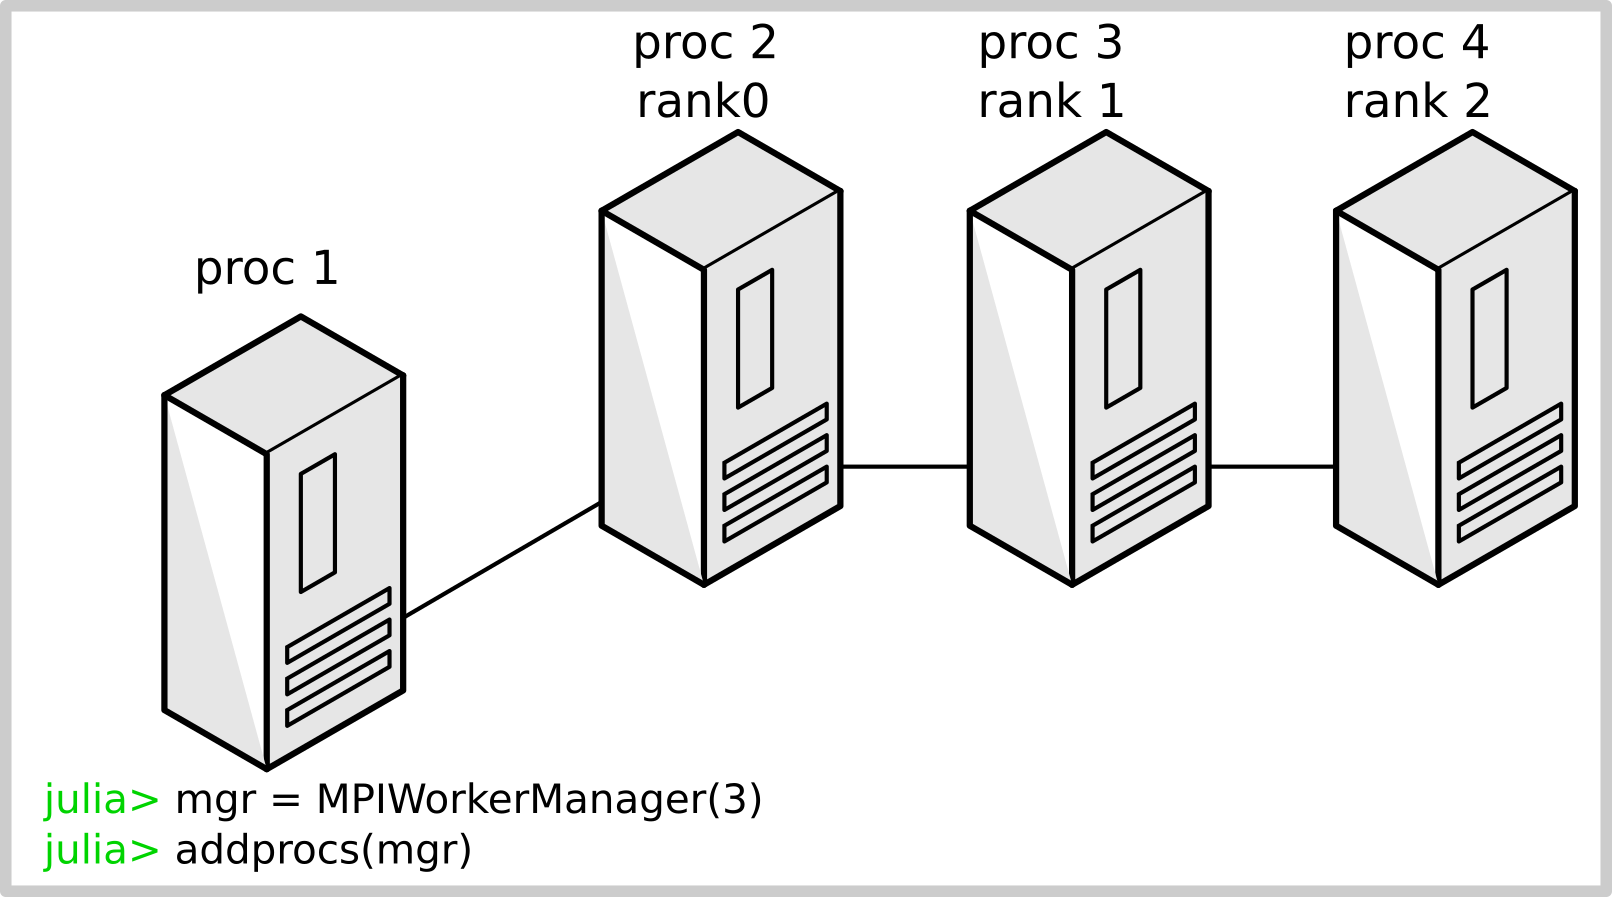
</div>
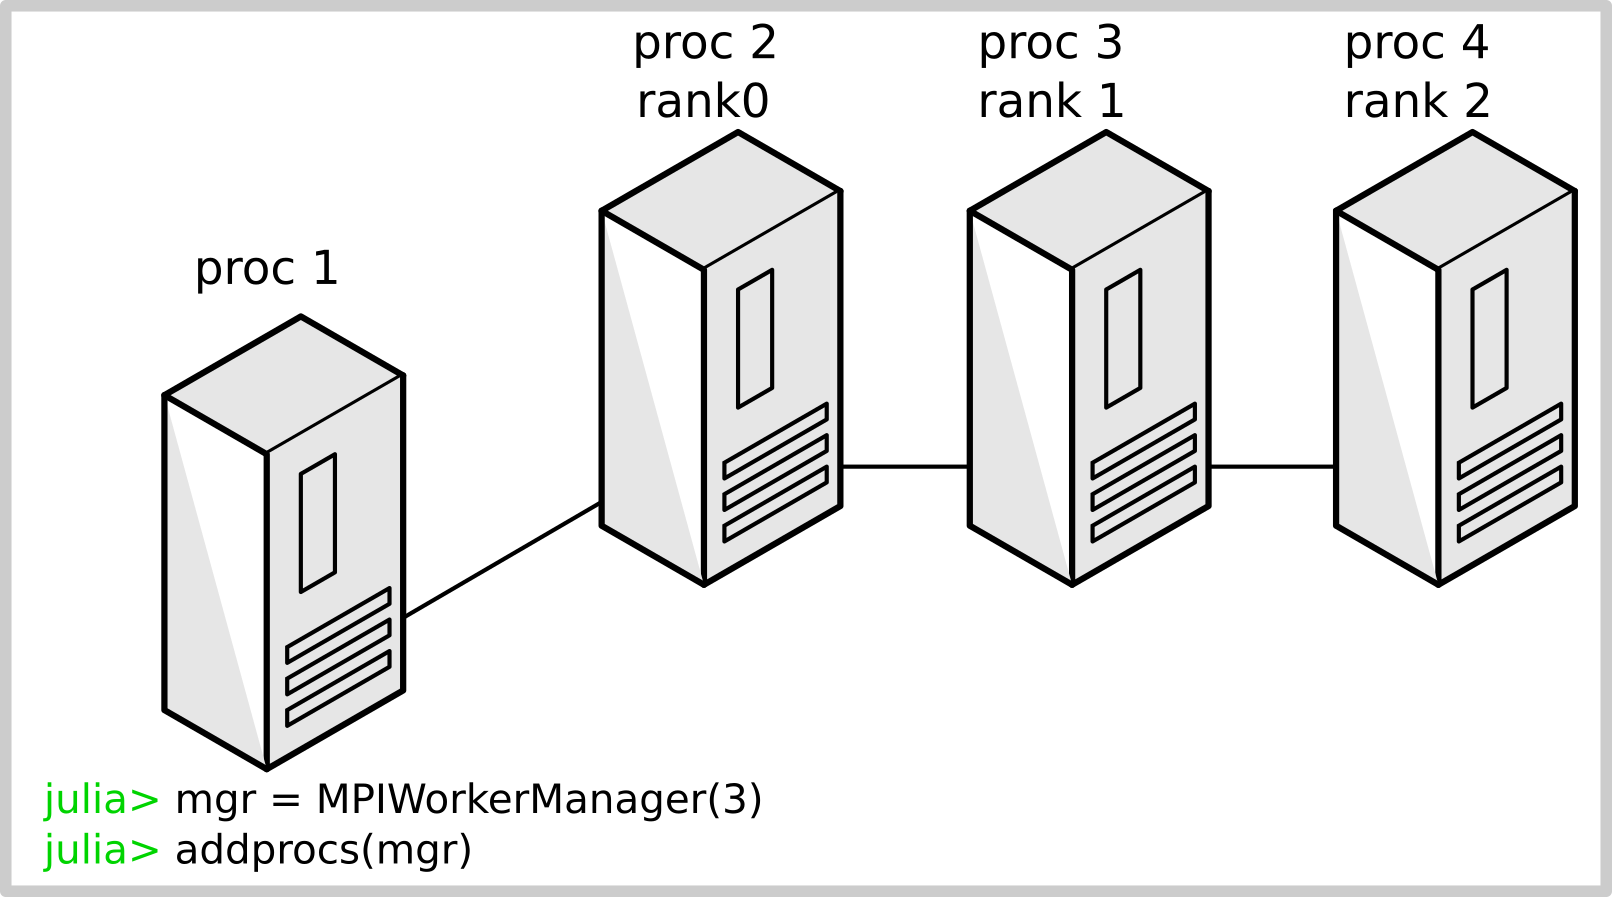

In [ ]:
] add MPIClusterManagers

In [ ]:
using MPIClusterManagers
using Distributed
if procs() == workers()
    nranks = 3
    manager = MPIWorkerManager(nranks)
    addprocs(manager)
end

In [ ]:
@everywhere workers() begin
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    println("Hello, I am process $rank of $nranks processes!")
end

<div class="alert alert-block alert-info">
<b>Note:</b> Note that the rank ids start with 0.
</div>

## MPI Communicators

In MPI, a **communicator** represents a group of processes that can communicate with each other. `MPI_COMM_WORLD` (`MPI.COMM_WORLD` from Julia) is a built-in communicator that represents all processes available in the MPI program.  Custom communicators can also be created to group processes based on specific requirements or logical divisions.  The **rank** of a processor is a unique (integer) identifier assigned to each process within a communicator. It allows processes to distinguish and address each other in communication operations.

### Duplicating a communicator

It is a good practice to not using the built-in communicators directly, and use a copy instead with `MPI.Comm_dup`. Different libraries using the same communicator can lead to unexpected interferences.

## Collective communication

MPI provides collective communication functions for communication involving multiple processes. Some usual collective directives are:

- `MPI.Scatter`: Distributes data from one process to all processes.
- `MPI.Gather`: Gathers data from all processes to a single process.
- `MPI.Bcast`: Broadcasts data from one process to all processes.
- `MPI.Barrier`: Synchronizes all processes.

See more collective directives available from Julia here: https://juliaparallel.org/MPI.jl/stable/reference/collective/


### Scatter

The "root" rank contains a buffer (e.g., a vector) of values (one value for each rank in a communicator). Scatter sends one value to each rank (the root rank also receives a value). The root rank can be any process in a communicator.

<div>
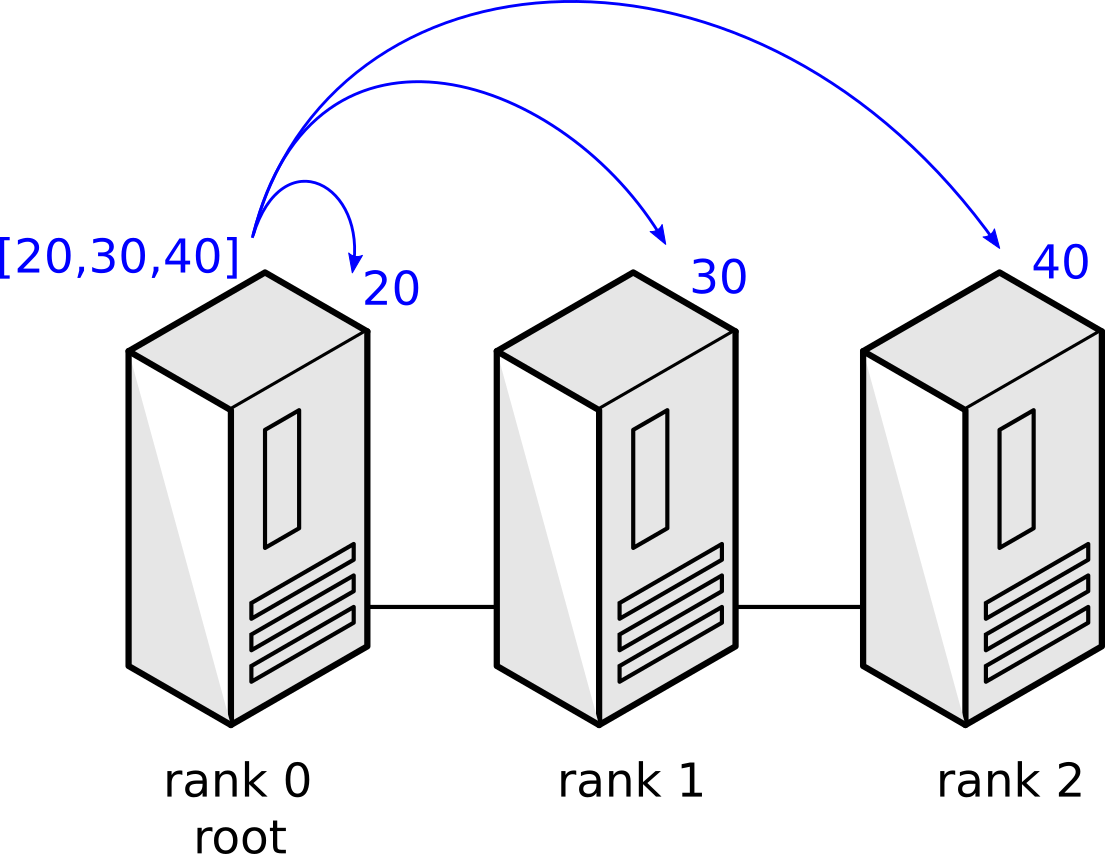
</div>
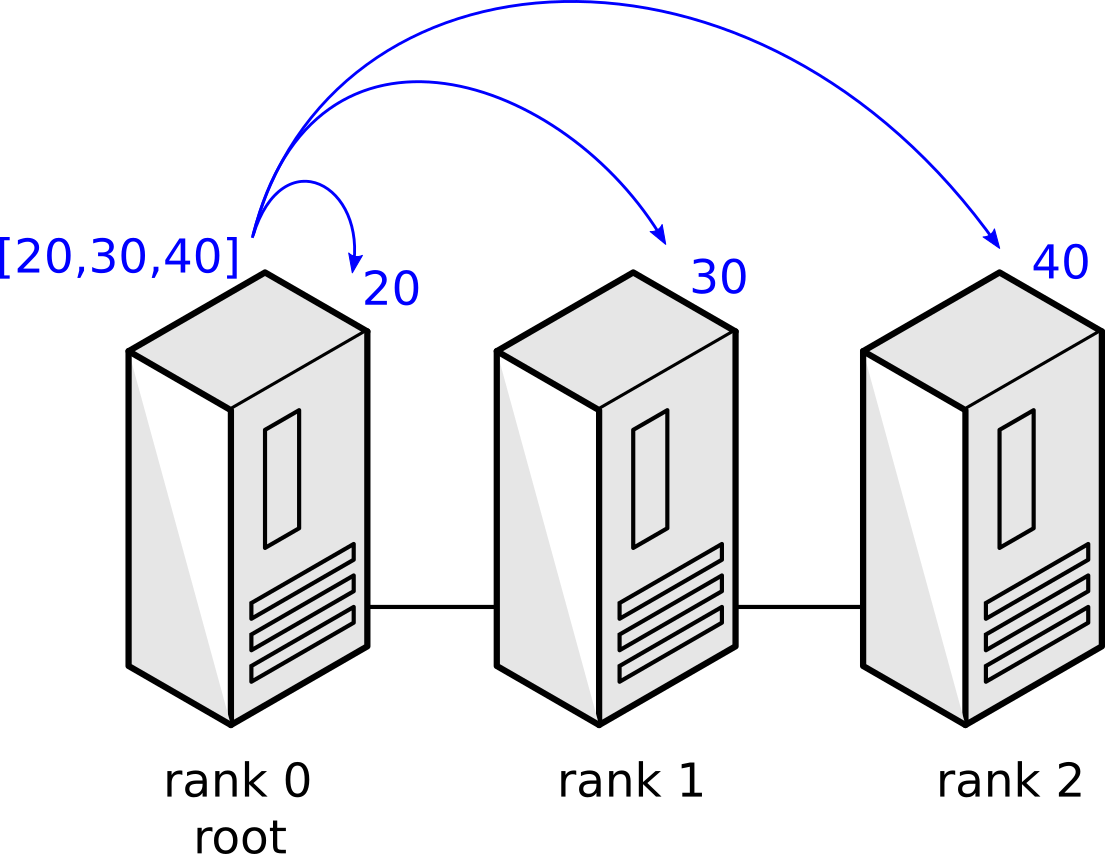

In [ ]:
@everywhere workers() begin
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    rcv = Ref(0) 
    if rank == root
        snd = [10*(i+1) for i in 1:nranks]
        println("I am sending: $snd")
    else
        snd = nothing
    end    
    MPI.Scatter!(snd,rcv,comm;root)
    println("I have received: $(rcv[])")
end

### Gather

Each rank sends a message to the root rank (the root rank also sends a message to itself). The root rank receives all these values in a buffer (e.g. a vector).

<div>
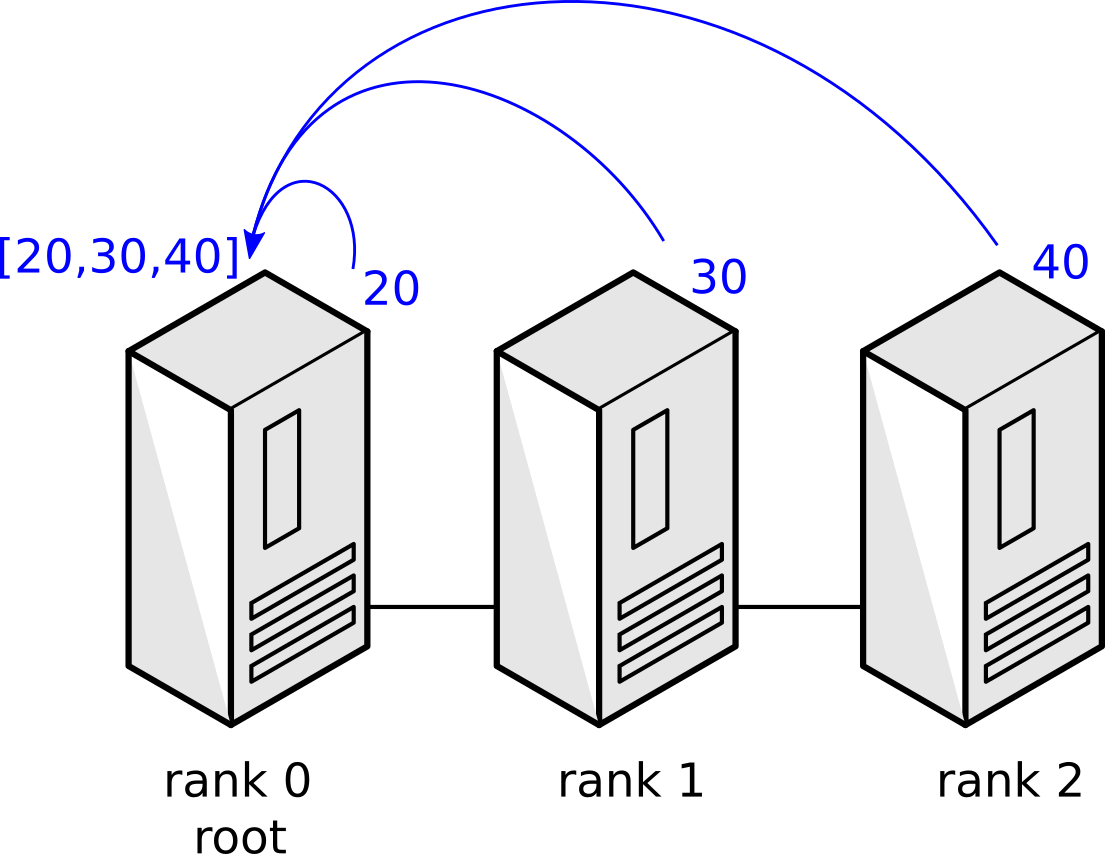
</div>
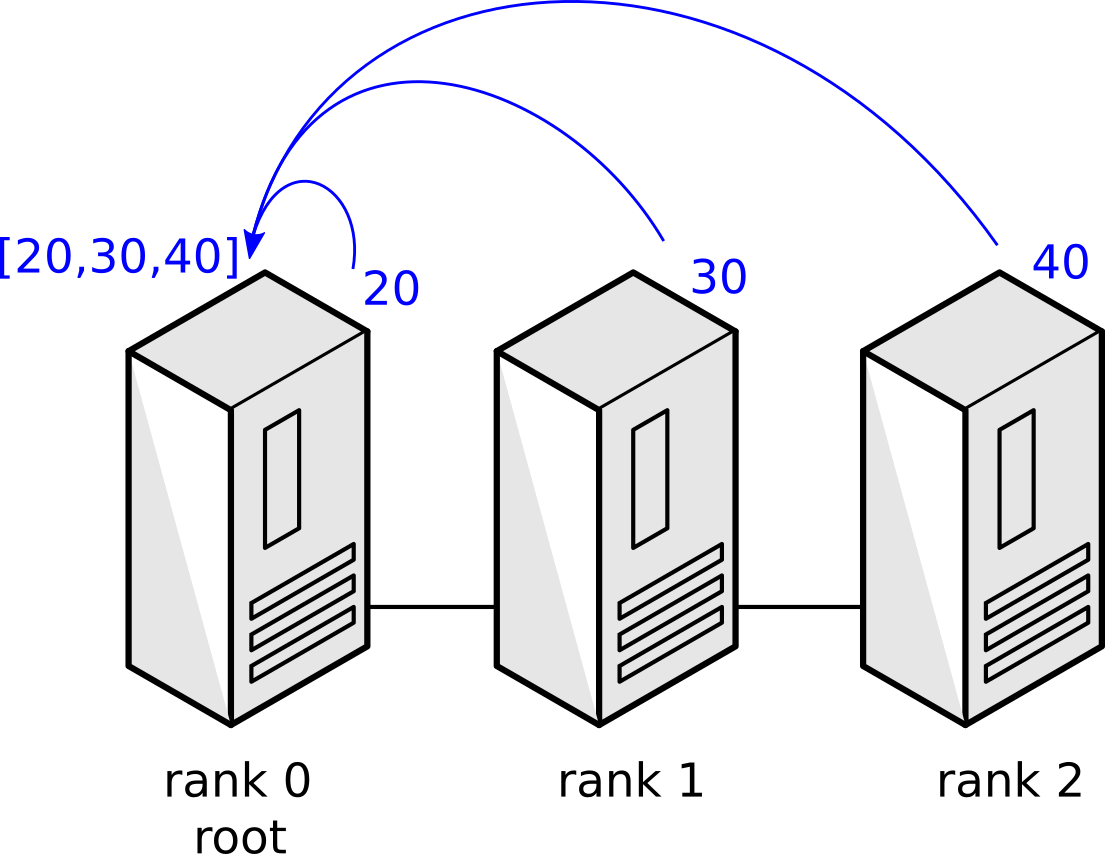

In [ ]:
@everywhere workers() begin
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    snd = 10*(rank+2)
    println("I am sending $snd")
    rcv = MPI.Gather(snd,comm;root)
    if rank == root
        println("I have received: $rcv")
    end
end

## Point-to-Point communication


MPI also provides point-to-point communication directives for arbitrary communication between processes. Point-to-point communications are two-sided: there is a sender and a receiver. Here, we will discuss these basic directives:

- `MPI.Isend`, and `MPI.Irecv!` (*non-blocking directives*)
- `MPI.Send`, and `MPI.Recv` (*blocking directives*)


Non-blocking directives return immediately and return an `MPI.Request` object. This request object can be queried with functions like `MPI.Wait`. It is mandatory to wait on the request object before reading the receive buffer, or before writing again on the send buffer.

For blocking directives, it is save to read/write from/to the receive/send buffer once the function has returned. By default, blocking directives might wait (or might not wait) for a matching send/receive. 
For fine control,  MPI offers advanced *blocking* directives with different blocking behaviors (called communication modes, see section 3.9 of the MPI standard 4.0). Blocking communication will be discussed later in the course.



### Example

The first rank generates a message and sends it to the last rank. The last rank receives the message and multiplies it by a coefficient. The last rank sends the result back to the first rank.

<div>
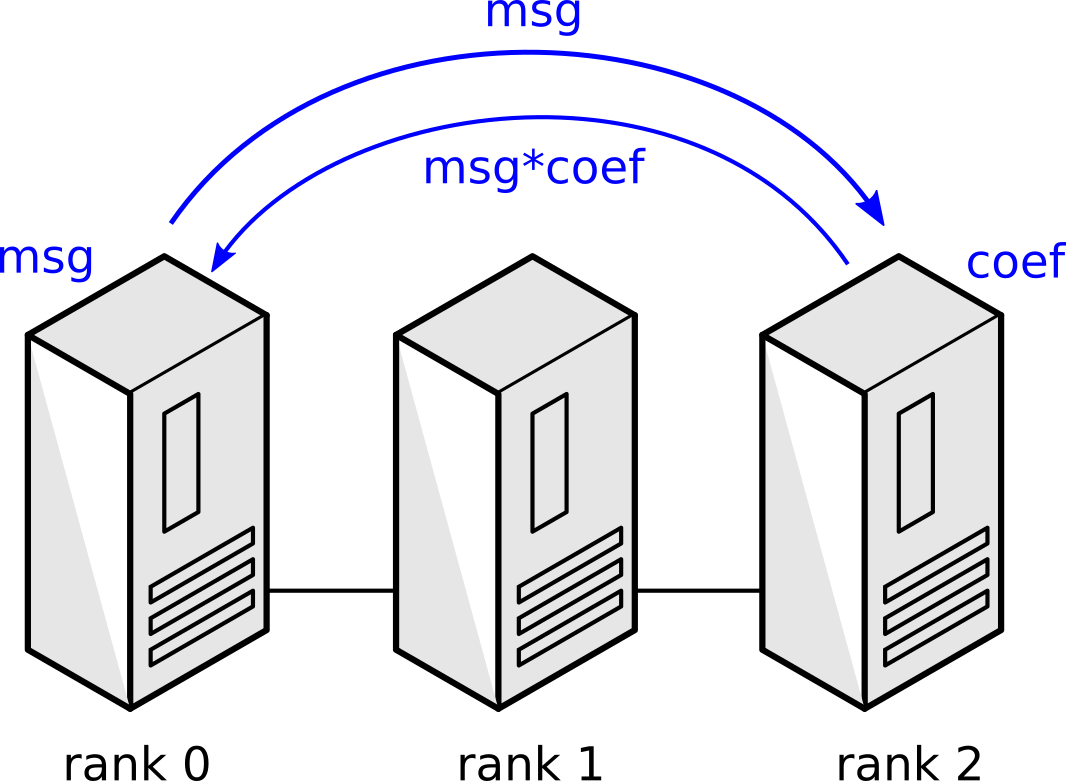
</div>

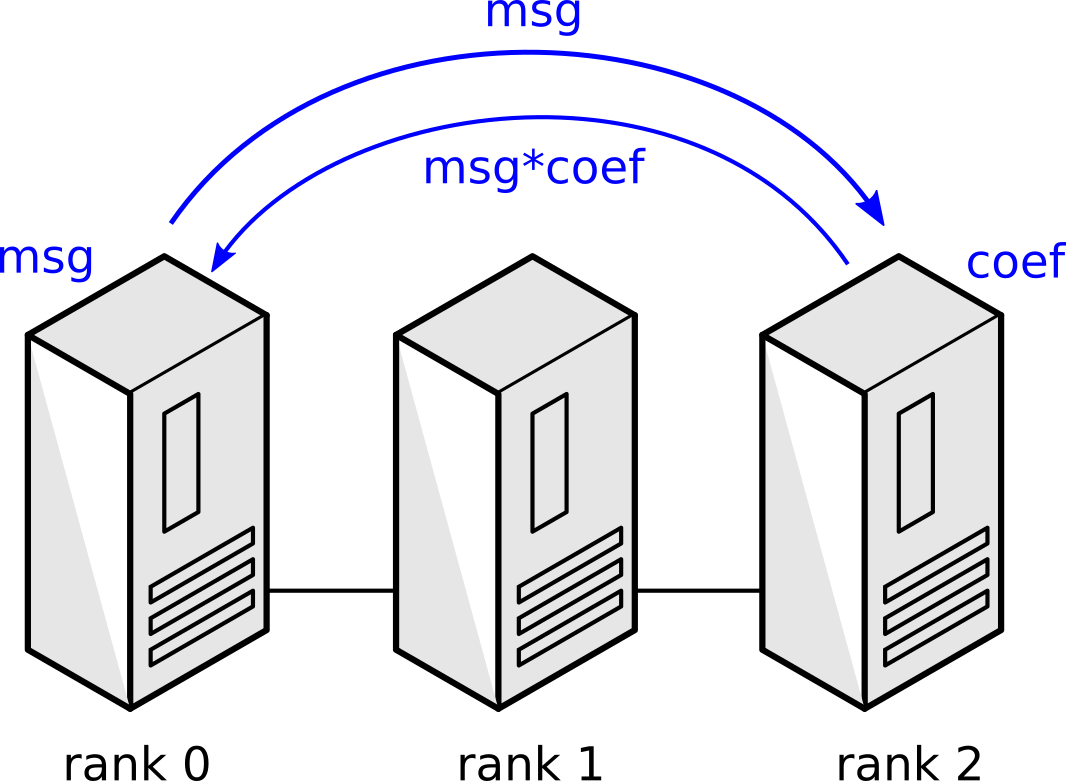

In [ ]:
@everywhere workers() begin
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    snder = 0
    rcver = nranks-1
    buffer = Ref(0)
    if rank == snder
        msg = 10*(rank+2)
        println("I am sending: $msg")
        buffer[] = msg
        req = MPI.Isend(buffer,comm;dest=rcver,tag=0)
        MPI.Wait(req)
        req = MPI.Irecv!(buffer,comm,source=rcver,tag=0)
        MPI.Wait(req)
        msg = buffer[]
        println("I have received: $msg")
    end
    if rank == rcver
        req = MPI.Irecv!(buffer,comm,source=snder,tag=0)
        MPI.Wait(req)
        msg = buffer[]
        println("I have received: $msg")
        coef = (rank+2)
        msg = msg*coef
        println("I am sending: $msg")
        buffer[] = msg
        req = MPI.Isend(buffer,comm;dest=snder,tag=0)
        MPI.Wait(req)
    end
end

<div class="alert alert-block alert-warning">
<b>Important:</b> In non-blocking communication, use <code>MPI.Wait()</code> before modifying the send buffer or using the receive buffer.
</div>

### Example (with blocking directives)

In [ ]:
@everywhere workers() begin
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    snder = 0
    rcver = nranks-1
    buffer = Ref(0)
    if rank == snder
        msg = 10*(rank+2)
        println("I am sending: $msg")
        buffer[] = msg
        MPI.Send(buffer,comm;dest=rcver,tag=0)
        MPI.Recv!(buffer,comm,source=rcver,tag=0)
        msg = buffer[]
        println("I have received: $msg")
    end
    if rank == rcver
        MPI.Recv!(buffer,comm,source=snder,tag=0)
        msg = buffer[]
        println("I have received: $msg")
        coef = (rank+2)
        msg = msg*coef
        println("I am sending: $msg")
        buffer[] = msg
        MPI.Send(buffer,comm;dest=snder,tag=0)
    end
end

<div class="alert alert-block alert-warning">
<b>Important:</b> Blocking directives might look simpler to use, but they can lead to dead locks if the sends and receives are not issued in the right order. Non-blocking directives can also lead to dead locks, but when waiting for the request, not when calling the send/receive functions.
</div>

## Exercises

### Exercise 1

Implement this simple algorithm: Rank 0 generates a message (an integer). Rank 0 sends the message to rank 1. Rank 1 receives the message, increments the message by 1, and sends the result to rank 2. Rank 2 receives the message, increments the message by 1, and sends the result to rank 3. Etc. The last rank sends back the message to rank 0 closing the ring. See the next figure. Implement the communications using MPI.


<div>
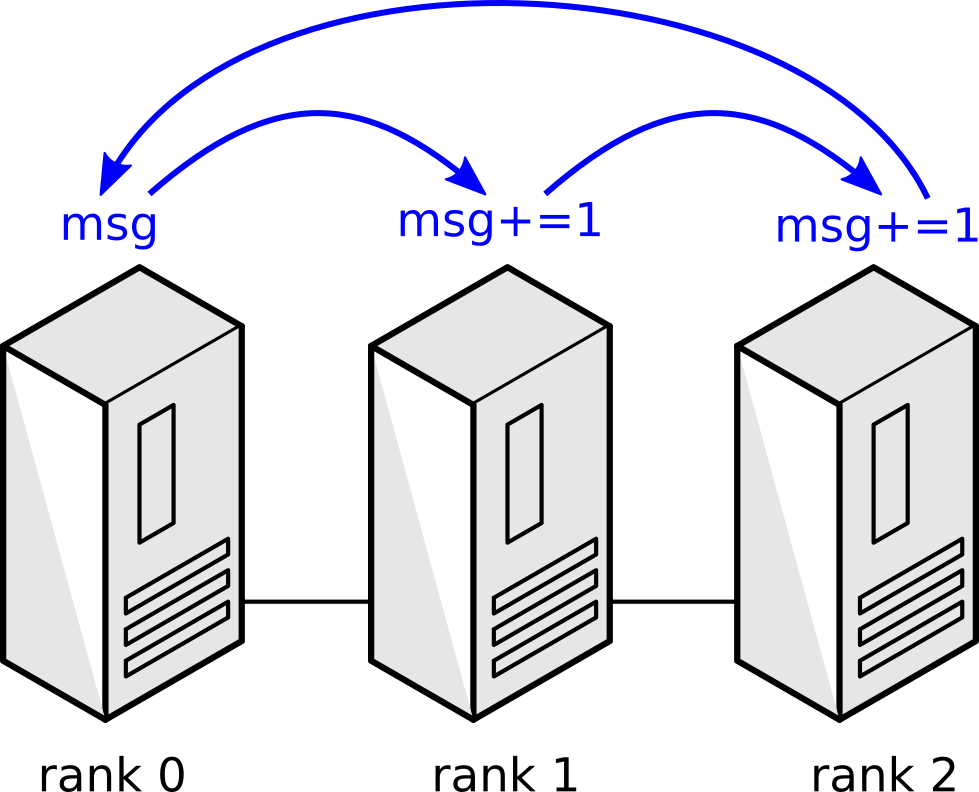
</div>
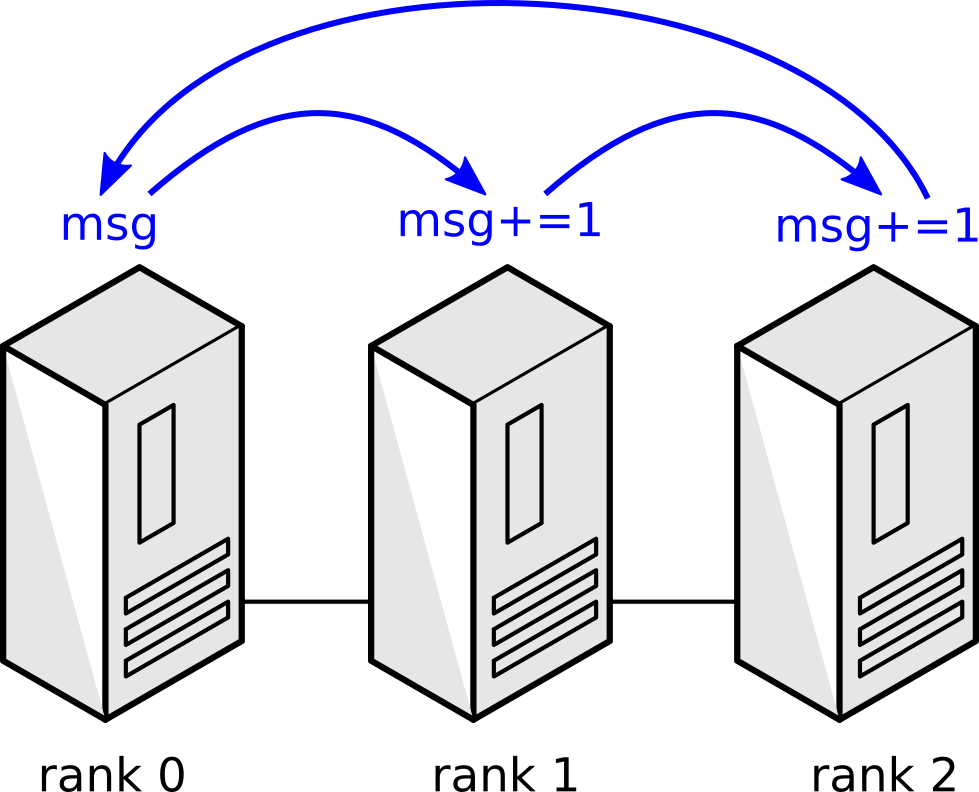

### Exercise 2

Implement the same algorithm as in Exercise 1, but now without using MPI. Implement the communications using the native `Distributed` module provided by Julia. In this case, start using process 1 instead of rank 0.

# License

This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.